In [108]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style("whitegrid")
# sns.set_theme()
matplotlib.rcParams['figure.figsize'] = [7, 4]

In [109]:
names = ["MSCI World", "MSCI EM", "Gold"]
urls = [
    "https://github.com/aadeg/Stock-Indexes-Historical-Data/raw/refs/heads/main/NET/USD/LARGE_AND_MID_CAP/REGIONS/MSCI%20WORLD.csv",
    "https://github.com/aadeg/Stock-Indexes-Historical-Data/raw/refs/heads/main/NET/EUR/LARGE_AND_MID_CAP/REGIONS/MSCI%20EM%20(EMERGING%20MARKETS).csv",
    "https://github.com/aadeg/Stock-Indexes-Historical-Data/raw/refs/heads/main/NET/EUR/EXTRA/IQ12260E.csv",
]

## Download degli indici

In [110]:
df = []
for url in urls:
    d = pd.read_csv(url, index_col=0, parse_dates=True)
    df.append(d)
df = pd.concat(df, axis=1, sort=True)

<Axes: >

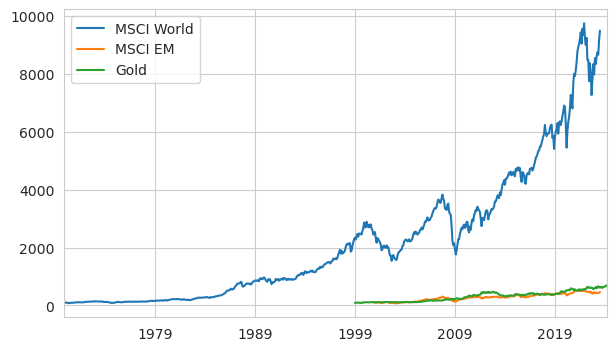

In [111]:
df.columns = names
df.plot()

In [112]:

df = df.dropna(how="any")
df

,MSCI World,MSCI EM,Gold
2000-12-01,2487.613434,100.000000,101.193012
2001-01-01,2535.516204,114.847013,104.211431
2001-02-01,2320.953678,107.036103,102.909249
2001-03-01,2168.116678,100.360134,106.549920
2001-04-01,2327.938366,105.004105,105.814740
...,...,...,...
2023-03-01,8603.222564,436.639191,590.875644
2023-04-01,8754.033498,424.828416,636.322464
2023-05-01,8666.638323,432.541944,660.972405
2023-06-01,9190.777442,438.718696,629.853480


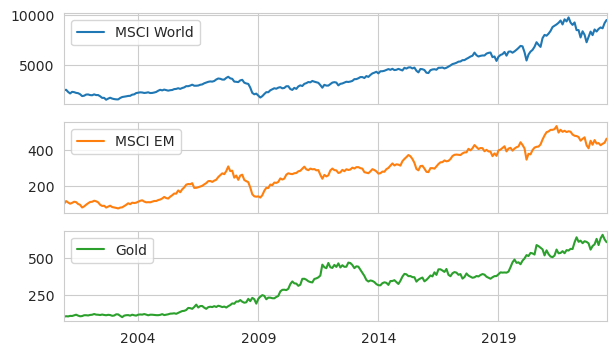

In [113]:
df.plot(subplots=True);

## Portafoglio base

In [114]:
anni = 5
pesi = np.array([0.50, 0.4, 0.10])

In [115]:
names

['MSCI World', 'MSCI EM', 'Gold']

In [116]:
ptf = (df.shift(-anni*12) / df) - 1
ptf = ptf.dropna(how="any")
ptf["RTOT"] = (ptf * pesi).sum(axis=1)
ptf.head()

,MSCI World,MSCI EM,Gold,RTOT
2000-12-01,0.114052,0.906552,0.394443,0.459091
2001-01-01,0.141811,0.792691,0.408837,0.428865
2001-02-01,0.245509,0.956758,0.563731,0.561831
2001-03-01,0.362627,1.074170,0.496046,0.660586
2001-04-01,0.307607,1.040161,0.462788,0.616147


<Axes: >

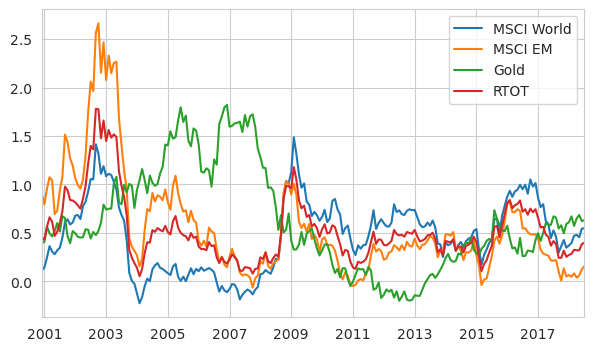

In [117]:
ptf.plot()

### Statistiche

In [118]:
ptf.RTOT.describe()

count    212.000000
mean       0.523188
std        0.331037
min        0.052478
25%        0.309698
50%        0.459208
75%        0.627832
max        1.780259
Name: RTOT, dtype: float64

VaR:

In [119]:
var = ptf.RTOT.quantile(0.05)
var

0.1404335640966622

CVaR:

In [120]:
cvar = ptf.RTOT[ptf.RTOT < var].mean()
cvar

0.11271549732625301

## Portafoglio al variare dell'allocazione

In [ ]:
def get_ptf(df, anni, pesi):
    ptf = (df.shift(-anni*12) / df) - 1
    ptf = ptf.dropna(how="any")
    ptf["RTOT"] = (ptf * pesi).sum(axis=1)
    return ptf

def ptf_stats(ptf):
    d = ptf.describe()
    d.loc["VaR", :] = ptf.quantile(0.05)
    d.loc["CVaR", :] = ptf[ptf <= d.loc["VaR", :]].mean()
    return d

### Portafogli benchmark

In [122]:
ptfs = pd.DataFrame()
ptfs["RTOT_WORLD"] = get_ptf(df, anni, [1.0, 0, 0]).RTOT
ptfs["RTOT_EM"] = get_ptf(df, anni, [0.0, 1.0, 0]).RTOT
ptfs["RTOT_Gold"] = get_ptf(df, anni, [0.0, 0.0, 1.0]).RTOT

In [123]:
ptf_stats(ptfs)

,RTOT_WORLD,RTOT_EM,RTOT_Gold
count,212.000000,212.000000,212.000000
mean,0.475028,0.559241,0.619775
std,0.364495,0.531926,0.524086
min,-0.227125,-0.064029,-0.201949
25%,0.142355,0.224946,0.280256
50%,0.461234,0.389903,0.511933
75%,0.719059,0.740061,0.979152
max,1.485938,2.663560,1.820223
VaR,-0.090287,0.026634,-0.122303
CVaR,-0.136553,-0.012589,-0.169661


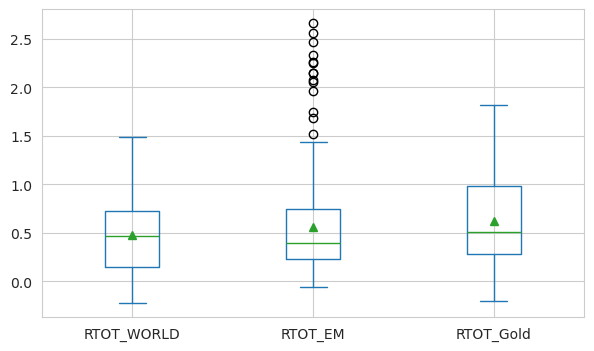

In [124]:
ptfs.plot(kind="box", showmeans=True);

## Random sampling

In [125]:
n_samples = 1000
w_12 = np.random.rand(n_samples, 2)
w_df = pd.DataFrame(w_12, columns=["w1", "w2"])
w_df = w_df[w_df.w1 + w_df.w2 <= 1]
w_df["w3"] = 1 - w_df.w1 - w_df.w2
w = w_df.to_numpy()

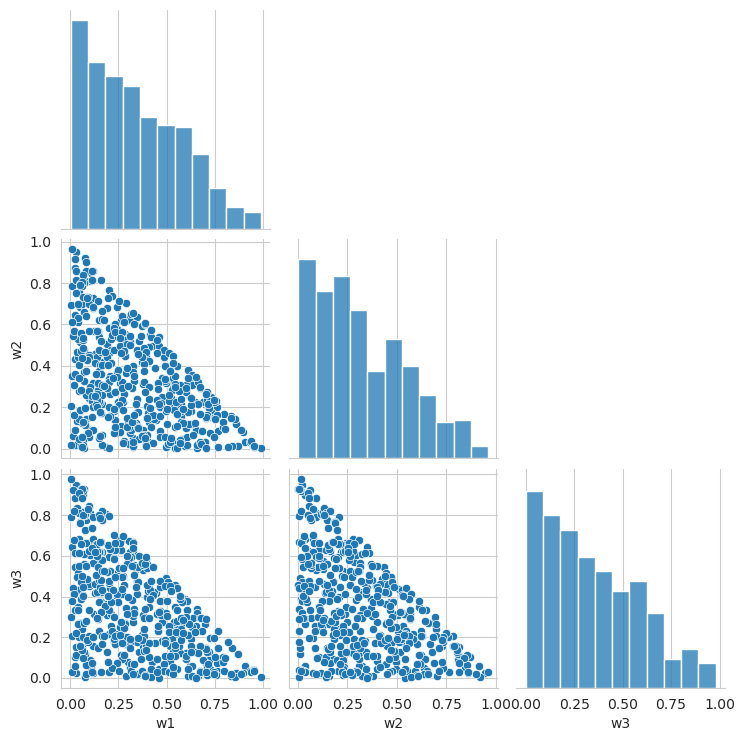

In [126]:
sns.pairplot(w_df, corner=True);

In [127]:
ptf_rnd0 = get_ptf(df, anni, w[0, :])
ptf_rnd = ptf_rnd0.RTOT.to_numpy()
ptf_rnd = np.repeat(ptf_rnd.reshape((-1, 1)), w.shape[0], axis=1)

for i in range(1, w.shape[0]):
    p = get_ptf(df, anni, w[i, :]).RTOT.to_numpy()
    ptf_rnd[:, i] = p

ptf_rnd = pd.DataFrame(ptf_rnd, index=ptf_rnd0.index)
ptf_rnd.head()

,0,1,2,3,4,5,6,7,8,9,...,462,463,464,465,466,467,468,469,470,471
2000-12-01,0.628814,0.599946,0.797574,0.282750,0.559538,0.650975,0.445571,0.329949,0.418540,0.363026,...,0.264379,0.529546,0.556440,0.802199,0.275267,0.343598,0.382698,0.510615,0.711275,0.441907
2001-01-01,0.567476,0.552170,0.704938,0.281635,0.512280,0.594274,0.442525,0.342100,0.414865,0.365945,...,0.281886,0.490204,0.515309,0.708036,0.289842,0.335021,0.391282,0.479107,0.639648,0.435605
2001-02-01,0.712734,0.702054,0.862126,0.399217,0.653642,0.748203,0.594572,0.480902,0.560418,0.504568,...,0.410526,0.631358,0.660961,0.865005,0.418510,0.460010,0.538860,0.622433,0.794799,0.584196
2001-03-01,0.815493,0.762511,0.970686,0.509995,0.747818,0.807700,0.568692,0.482481,0.562007,0.522878,...,0.444098,0.712656,0.727087,0.977099,0.457051,0.553637,0.510969,0.681324,0.875208,0.577997
2001-04-01,0.775248,0.724777,0.934470,0.459944,0.706399,0.771395,0.533552,0.442144,0.524021,0.482123,...,0.399542,0.671439,0.687760,0.940732,0.412399,0.506530,0.474316,0.641341,0.838883,0.541235


### Rendimento atteso vs deviazione standard

In [128]:
stats = ptf_stats(ptf_rnd)

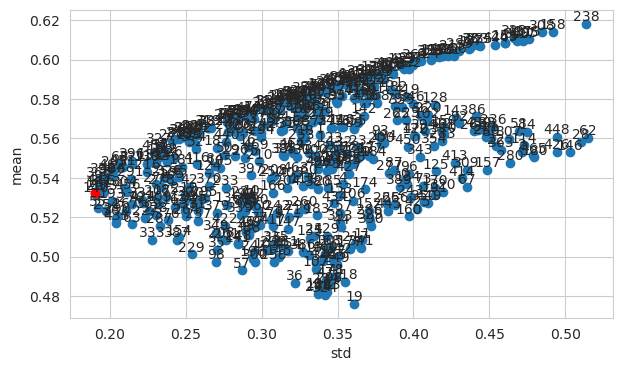

In [129]:
idxmin = stats.loc["std", :].idxmin()

x = stats.loc["std", :]
y = stats.loc["mean", :]
t = stats.columns.to_numpy()
plt.figure()
plt.scatter(x, y)
plt.scatter(x[idxmin], y[idxmin], c='r')
for (xi, yi, ti) in zip(x, y, t):
    plt.text(xi, yi, ti, va="bottom", ha="center")
plt.xlabel("std")
plt.ylabel("mean")
plt.show()

In [130]:
w[idxmin, :]

array([0.59770856, 0.01422214, 0.3880693 ])

In [131]:
stats[idxmin]

count    212.000000
mean       0.532397
std        0.190248
min        0.188170
25%        0.378466
50%        0.527238
75%        0.645196
max        1.066799
VaR        0.271546
CVaR       0.236732
Name: 20, dtype: float64

### Rendimento atteso vs CVaR

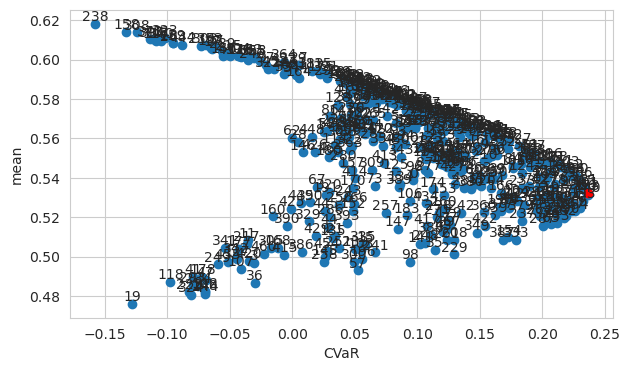

In [132]:
stats = ptf_stats(ptf_rnd)
idxmax = stats.loc["CVaR", :].idxmax()

x = stats.loc["CVaR", :]
y = stats.loc["mean", :]
t = stats.columns.to_numpy()
plt.figure()
plt.scatter(x, y)
plt.scatter(x[idxmax], y[idxmax], c='r')
for (xi, yi, ti) in zip(x, y, t):
    plt.text(xi, yi, ti, va="bottom", ha="center")
plt.xlabel("CVaR")
plt.ylabel("mean")
plt.show()

In [133]:
w[idxmax, :]

array([0.59770856, 0.01422214, 0.3880693 ])

In [134]:
stats[idxmax]

count    212.000000
mean       0.532397
std        0.190248
min        0.188170
25%        0.378466
50%        0.527238
75%        0.645196
max        1.066799
VaR        0.271546
CVaR       0.236732
Name: 20, dtype: float64

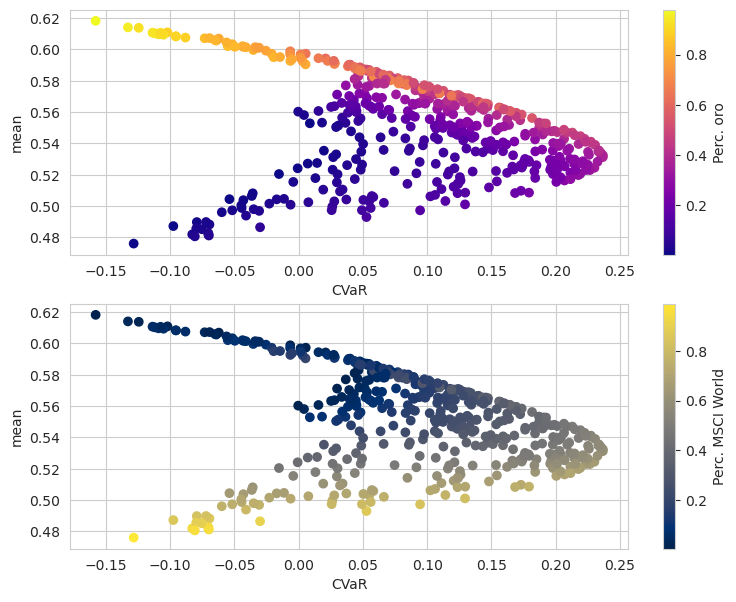

In [135]:
x = stats.loc["CVaR", :]
y = stats.loc["mean", :]
c = w[:, 2]  # percentuale di oro
t = stats.columns.to_numpy()
plt.figure(figsize=(9, 7))
plt.subplot(2, 1, 1)
plt.scatter(x, y, c=c, cmap="plasma")

plt.xlabel("CVaR")
plt.ylabel("mean")
plt.colorbar(label="Perc. oro")

plt.subplot(2, 1, 2)
c = w[:, 0]  # percentuale di World
plt.scatter(x, y, c=c, cmap="cividis")

plt.xlabel("CVaR")
plt.ylabel("mean")
plt.colorbar(label="Perc. MSCI World")
plt.show()

## Ottimizzazione

In [136]:
from scipy.optimize import minimize, LinearConstraint

In [137]:
optFn = lambda w: -ptf_stats(get_ptf(df, anni, w)[["RTOT"]]).loc["CVaR", "RTOT"]
x0 = [0.0, 1.0, 0]
#x0 = [1.0, 0.0, 0]
x0 = w[idxmax, :]
constraints = (
    LinearConstraint([1, 1, 1], lb=1, ub=1),
)
bounds = [(0, 1), (0, 1), (0, 1)]

opts = {"disp": True}
sol = minimize(optFn, x0, bounds=bounds, constraints=constraints, 
    options=opts)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.23711290650480157
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3


In [138]:
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.23711290650480157
       x: [ 6.074e-01  0.000e+00  3.926e-01]
     nit: 3
     jac: [-2.358e-01 -2.135e-01 -2.391e-01]
    nfev: 16
    njev: 3

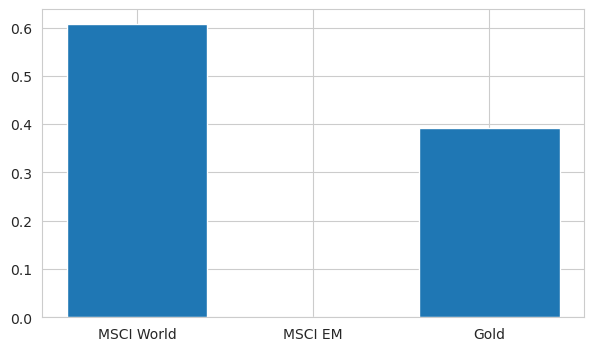

In [139]:
plt.figure()
plt.bar(names, sol.x);

In [140]:
pftOpt = get_ptf(df, anni, sol.x)
ptf_stats(pftOpt).RTOT

count    212.000000
mean       0.531859
std        0.187727
min        0.191637
25%        0.373657
50%        0.525316
75%        0.647462
max        1.046186
VaR        0.272824
CVaR       0.237113
Name: RTOT, dtype: float64

<Axes: >

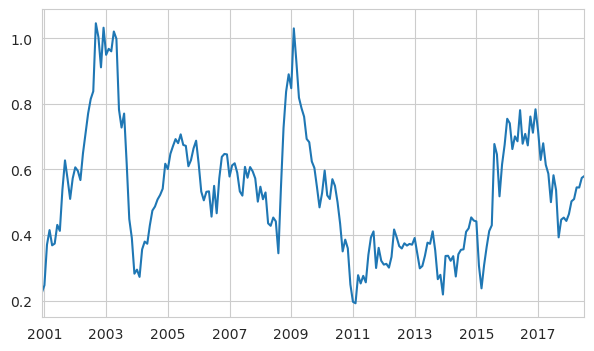

In [141]:
pftOpt.RTOT.plot()

In [142]:
ptfs["RTOT_Optim"] = pftOpt.RTOT

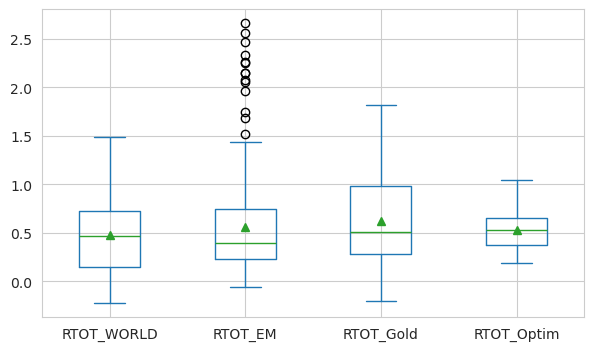

In [143]:
ptfs.plot(kind="box", showmeans=True);

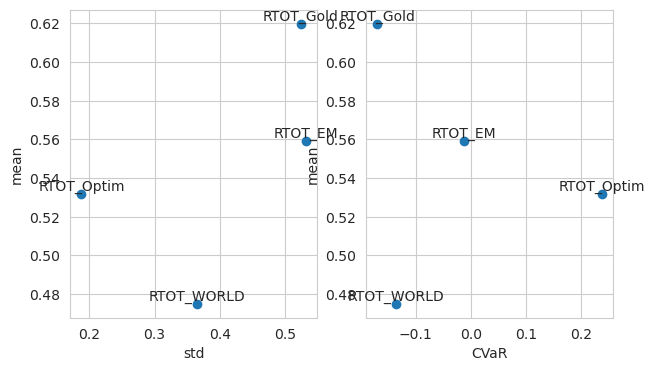

In [144]:
stats = ptf_stats(ptfs)
x = stats.loc["std", :]
y = stats.loc["mean", :]
t = stats.columns.to_numpy()
plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(x, y)
for (xi, yi, ti) in zip(x, y, t):
    plt.text(xi, yi, ti, va="bottom", ha="center")
plt.xlabel("std")
plt.ylabel("mean")


x = stats.loc["CVaR", :]
y = stats.loc["mean", :]
t = stats.columns.to_numpy()
plt.subplot(1, 2, 2)
plt.scatter(x, y)
for (xi, yi, ti) in zip(x, y, t):
    plt.text(xi, yi, ti, va="bottom", ha="center")
plt.xlabel("CVaR")
plt.ylabel("mean")
plt.show()